In [2]:
pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

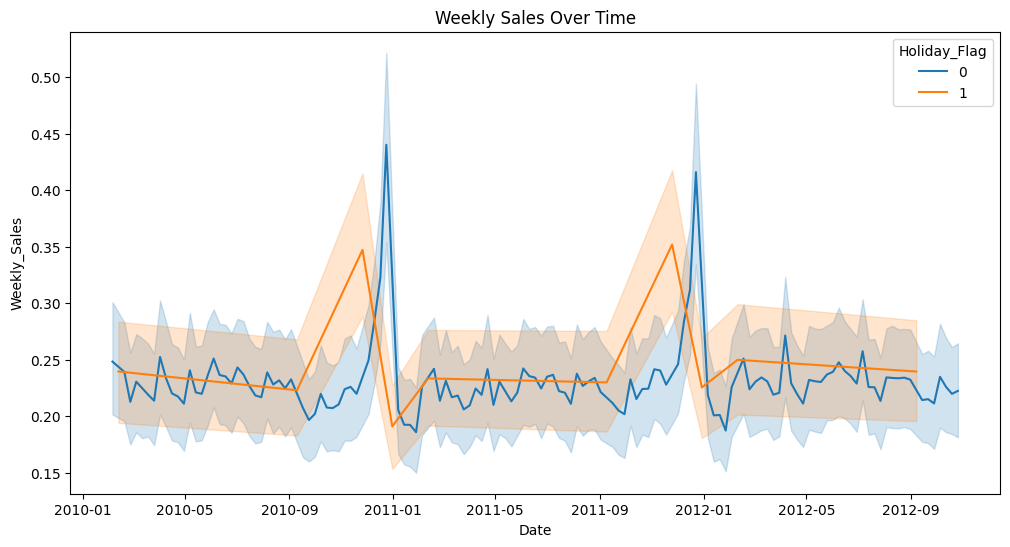

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import torch
import torchvision.transforms as transforms
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from PIL import Image
from datasets import load_dataset

walmart_df = pd.read_csv("/content/Walmart.csv")

walmart_df['Date'] = pd.to_datetime(walmart_df['Date'], format='%d-%m-%Y')
walmart_df.fillna(walmart_df.mean(), inplace=True)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
walmart_df[numeric_cols] = scaler.fit_transform(walmart_df[numeric_cols])

# Visualization of Sales Trends
plt.figure(figsize=(12,6))
sns.lineplot(data=walmart_df, x='Date', y='Weekly_Sales', hue='Holiday_Flag')
plt.title('Weekly Sales Over Time')
plt.show()


In [5]:
from datasets import load_dataset

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", split="full")

reviews = dataset.to_pandas()

print(reviews.columns)


All_Beauty.jsonl:  16%|#6        | 52.4M/327M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')


In [6]:
import nltk

nltk.download('stopwords', force=True)
nltk.download('punkt', force=True)
nltk.download('punkt_tab', force=True)
nltk.download('wordnet', force=True)
nltk.download('omw-1.4', force=True)
nltk.download('averaged_perceptron_tagger', force=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

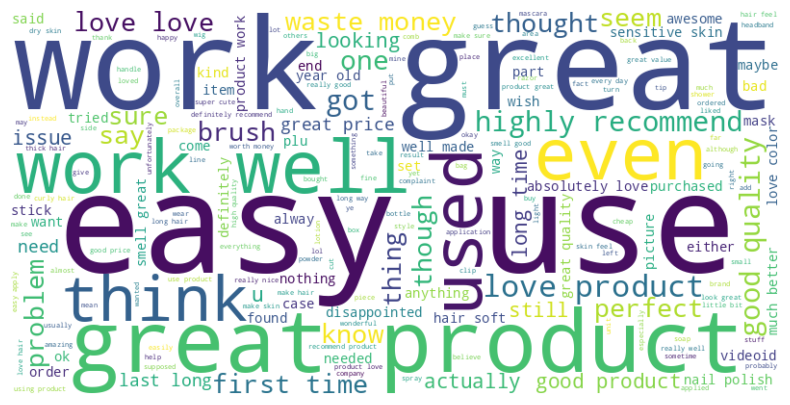

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<br\s*/?>', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

reviews['processed_text'] = reviews['text'].apply(preprocess_text)

# Word Cloud Visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(reviews['processed_text']))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
import pandas as pd
import torch
import multiprocessing
from PIL import Image
import requests
from transformers import CLIPModel, CLIPProcessor
from tqdm import tqdm

csv_path = "/content/product_image_urls.csv"
df = pd.read_csv(csv_path)

url_column = "image_url"

# Drop missing and invalid URLs
df = df.dropna(subset=[url_column])
df = df[df[url_column].str.startswith("http", na=False)]

# Limited to a subset of 50 images for faster processing
N = 50
df = df.head(N)

# Load CLIP model and processor once (shared among processes)
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Function to process a single image
def process_image(url):
    try:
        image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
        inputs = processor(images=image, return_tensors="pt", padding=True)

        with torch.no_grad():
            emb = model.get_image_features(pixel_values=inputs["pixel_values"]).squeeze().tolist()

        return url, emb
    except Exception as e:
        print(f"Failed to process: {url} | Error: {e}")
        return None

# Use multiprocessing to speed up processing
num_workers = 8
with multiprocessing.Pool(num_workers) as pool:
    results = list(tqdm(pool.imap(process_image, df[url_column].values), total=len(df)))

# Filter out failed results
valid_results = [r for r in results if r is not None]

embeddings_df = pd.DataFrame(valid_results, columns=["image_url", "embedding"])
embeddings_df.to_csv("/content/image_embeddings.csv", index=False)

print("✅ Image embeddings saved at: /content/image_embeddings.csv")


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

100%|██████████| 50/50 [03:11<00:00,  3.82s/it]


✅ Image embeddings saved at: /content/image_embeddings.csv


In [10]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.8 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

X = walmart_df.drop(columns=['Weekly_Sales', 'Date'])
y = walmart_df['Weekly_Sales']

# RFE with DecisionTree
dt_for_rfe = DecisionTreeRegressor()
rfe = RFE(estimator=dt_for_rfe, n_features_to_select=5)
X_rfe = rfe.fit_transform(X, y)
selected_features_rfe = X.columns[rfe.support_]

# Lasso for feature selection
lasso = LassoCV(cv=5).fit(X, y)
selected_features_lasso = X.columns[(lasso.coef_ != 0)]

# Intersect both selections
final_features = list(set(selected_features_rfe) & set(selected_features_lasso))
if not final_features:
    final_features = list(set(selected_features_rfe) | set(selected_features_lasso))

print("Selected Features:", final_features)




In [46]:
X = walmart_df[final_features]
y = walmart_df['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(),
    "SVM": SVR(),
    "CatBoost": CatBoostRegressor(verbose=0),
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

# Hyperparameters for GridSearchCV
param_grid = {
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
    "Decision Tree": {
        "max_depth": [10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"],
        "kernel": ["linear", "rbf"]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    },
    "LightGBM": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "num_leaves": [31, 50, 100]
    }
}

results = {}



Evaluating Linear Regression...
Linear Regression - Cross-validation MSE: -0.021699712963158074
Linear Regression Evaluation:
R² Score: 0.1175
MSE: 0.02


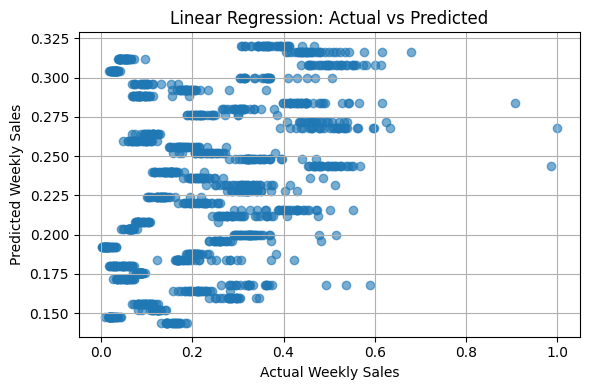


Evaluating Random Forest...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}
Random Forest - Cross-validation MSE: -0.0020794166000168627
Random Forest Evaluation:
R² Score: 0.9182
MSE: 0.0


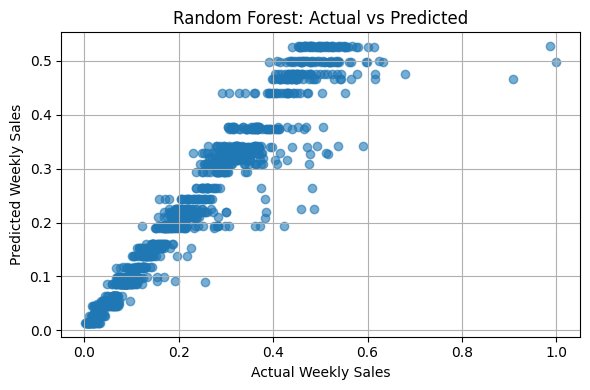


Evaluating Decision Tree...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters for Decision Tree: {'max_depth': 20, 'min_samples_split': 2}
Decision Tree - Cross-validation MSE: -0.0020810376483969928
Decision Tree Evaluation:
R² Score: 0.9182
MSE: 0.0


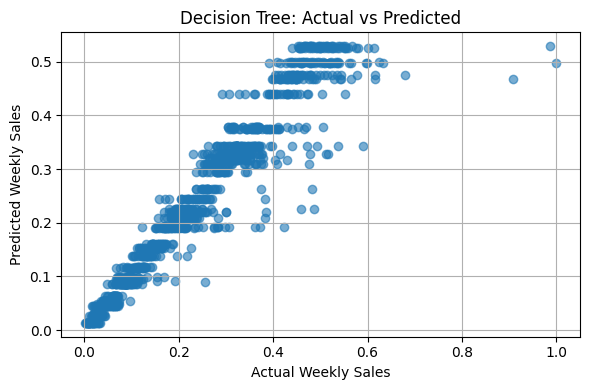


Evaluating SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
SVM - Cross-validation MSE: -0.004927632740704422
SVM Evaluation:
R² Score: 0.7982
MSE: 0.0


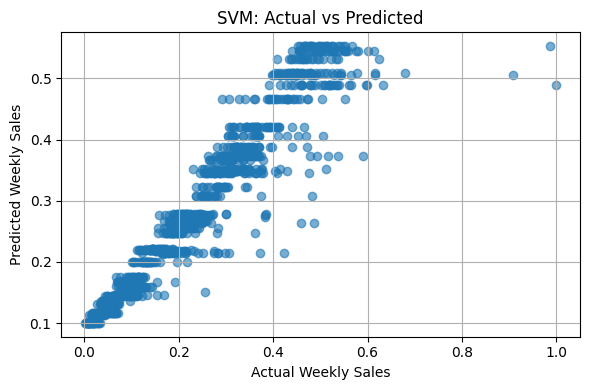


Evaluating CatBoost...
CatBoost - Cross-validation MSE: -0.002080795667422369
CatBoost Evaluation:
R² Score: 0.9182
MSE: 0.0


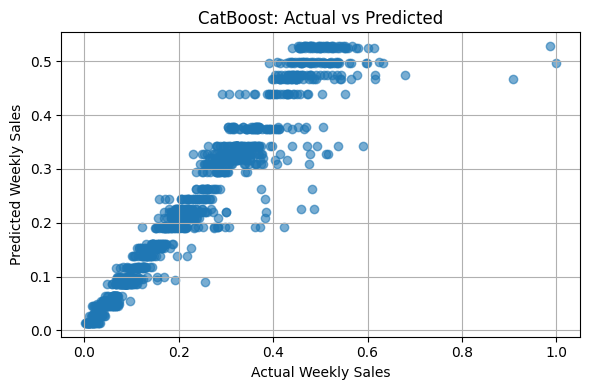


Evaluating XGBoost...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
XGBoost - Cross-validation MSE: -0.0020805221459713748
XGBoost Evaluation:
R² Score: 0.9183
MSE: 0.0


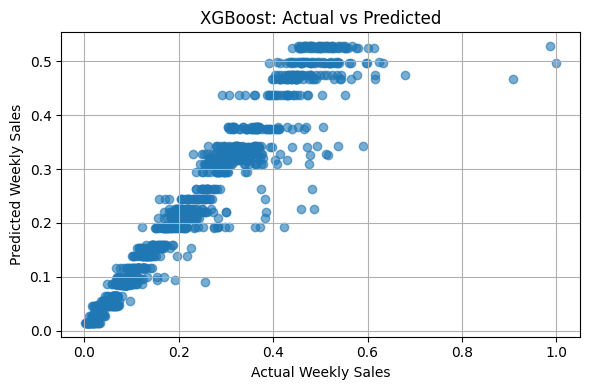


Evaluating LightGBM...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 5148, number of used features: 1
[LightGBM] [Info] Start training from score 0.231388
Best Parameters for LightGBM: {'learning_rate': 0.2, 'n_estimators': 50, 'num_leaves': 31}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 3432, number of used features: 1
[LightGBM] [Info] Start training from score 0.229435
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove 

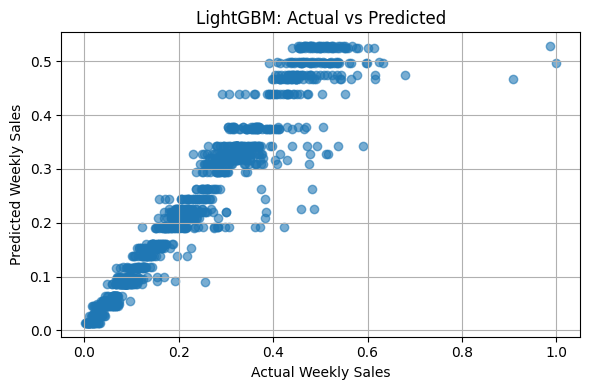

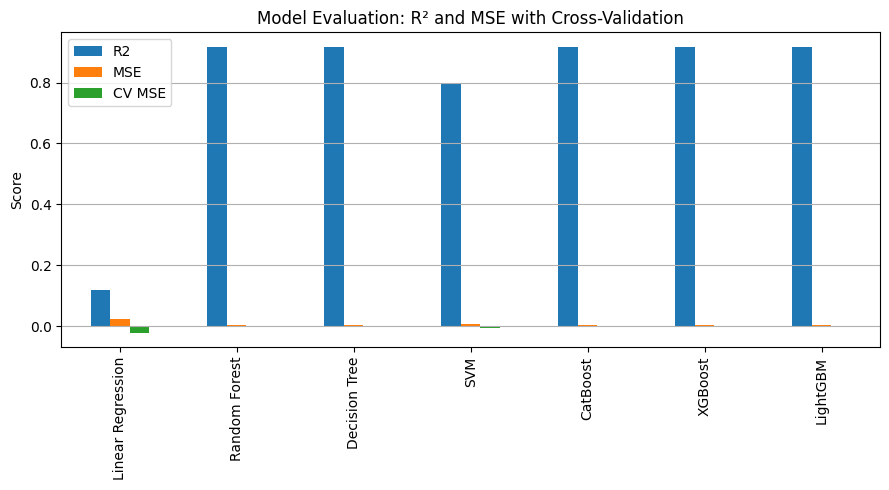

In [49]:
# Train, predict, evaluate, and plot with cross-validation
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    # Apply GridSearchCV for hyperparameter tuning
    if name in param_grid:
        grid_search = GridSearchCV(model, param_grid[name], cv=3, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best Parameters for {name}: {grid_search.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train, y_train)

    # Cross-validation for model performance
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=3, scoring="neg_mean_squared_error")
    mean_cv_score = cv_scores.mean()
    print(f"{name} - Cross-validation MSE: {mean_cv_score}")

    # Predictions
    preds = best_model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    results[name] = {"R2": r2, "MSE": mse, "CV MSE": mean_cv_score}

    print(f"{name} Evaluation:")
    print("R² Score:", round(r2, 4))
    print("MSE:", round(mse, 2))

    # Prediction vs Actual scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, preds, alpha=0.6)
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Weekly Sales")
    plt.ylabel("Predicted Weekly Sales")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Bar chart comparing model performances
metrics_df = pd.DataFrame(results).T
metrics_df.plot(kind='bar', figsize=(9, 5), title="Model Evaluation: R² and MSE with Cross-Validation")
plt.ylabel("Score")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dists = {
    "Decision Tree": {
        "max_depth": randint(3, 10),
        "min_samples_split": randint(2, 10)
    },
    "SVM": {
        "C": uniform(0.1, 10),
        "kernel": ["linear", "rbf"]
    },
    "CatBoost": {
        "depth": randint(4, 10),
        "learning_rate": uniform(0.01, 0.1),
        "iterations": randint(100, 300)
    }
}

n_iter_search = 10  # Number of parameter settings that are sampled

best_models = {}

for name, model in models.items():
    print(f"\nRunning RandomizedSearchCV for {name}...")
    search = RandomizedSearchCV(
        model,
        param_distributions=param_dists[name],
        n_iter=n_iter_search,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(f"Best params for {name}: {search.best_params_}")



Running RandomizedSearchCV for Decision Tree...
Best params for Decision Tree: {'max_depth': 9, 'min_samples_split': 5}

Running RandomizedSearchCV for SVM...
Best params for SVM: {'C': np.float64(1.934347898661638), 'kernel': 'rbf'}

Running RandomizedSearchCV for CatBoost...
Best params for CatBoost: {'depth': 5, 'iterations': 287, 'learning_rate': np.float64(0.046636184329369175)}


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, top_k_accuracy_score

# === Load and Prepare Data ===
df = pd.read_csv("/content/image_embeddings.csv")
df["embedding"] = df["embedding"].apply(lambda x: list(map(float, x.strip("[]").split(","))))
df = df.sample(n=50, random_state=42).reset_index(drop=True)
df["label"] = ["class_" + str(i % 5) for i in range(50)]
df["label_encoded"] = LabelEncoder().fit_transform(df["label"])

class EmbeddingDataset(Dataset):
    def __init__(self, df):
        self.embeddings = df["embedding"].tolist()
        self.labels = df["label_encoded"].tolist()

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float32), torch.tensor(self.labels[idx])

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label_encoded"], random_state=42)
train_loader = DataLoader(EmbeddingDataset(train_df), batch_size=8, shuffle=True)
test_loader = DataLoader(EmbeddingDataset(test_df), batch_size=8)

input_dim = len(df["embedding"][0])
num_classes = df["label_encoded"].nunique()

# === Define Models ===
class ResNetLike(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.res_block = nn.Sequential(nn.Linear(512, 512), nn.ReLU(), nn.Linear(512, 512))
        self.fc_out = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.res_block(x) + x
        return self.fc_out(x)

class EfficientNetLike(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.expand = nn.Linear(input_dim, 512)
        self.act = nn.SiLU()
        self.se = nn.Sequential(nn.Linear(512, 64), nn.ReLU(), nn.Linear(64, 512), nn.Sigmoid())
        self.fc_out = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.act(self.expand(x))
        x = x * self.se(x)
        return self.fc_out(x)

class MobileNetLike(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

class CNNOnEmbeddings(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool1d(2)
        )
        conv_out_dim = input_dim // 4 * 32
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_out_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, input_dim)
        x = self.conv(x)
        return self.fc(x)

# === Training Function ===
def train_model(model, train_loader, epochs=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(X), y)
            loss.backward()
            optimizer.step()
    return model

# === Evaluation Function ===
def evaluate_model_metrics(model, test_loader, top_k=(1, 5)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    all_labels, all_probs = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            probs = F.softmax(logits, dim=1)
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    y_true = np.array(all_labels)
    y_probs = np.array(all_probs)
    y_pred = np.argmax(y_probs, axis=1)

    results = {
        "Precision": precision_score(y_true, y_pred, average='macro'),
        "Recall": recall_score(y_true, y_pred, average='macro'),
        "F1-score": f1_score(y_true, y_pred, average='macro'),
    }

    for k in top_k:
        results[f"Top-{k} Accuracy"] = top_k_accuracy_score(y_true, y_probs, k=k)
    return results

# === Run and Compare All Models ===
models = {
    "ResNetLike": ResNetLike(input_dim, num_classes),
    "EfficientNetLike": EfficientNetLike(input_dim, num_classes),
    "MobileNetLike": MobileNetLike(input_dim, num_classes),
    "CNNOnEmbeddings": CNNOnEmbeddings(input_dim, num_classes)
}

results = {}
for name, model in models.items():
    trained_model = train_model(model, train_loader)
    metrics = evaluate_model_metrics(trained_model, test_loader)
    results[name] = {k: round(v, 3) for k, v in metrics.items()}

import pandas as pd
results_df = pd.DataFrame(results).T
results_df


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:2036: UndefinedMetricWarning: 'k' (5) greater than or equal to 'n_classes' (5) will result in a perfect score and is therefore meaningless.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:2036: UndefinedMetricWarning: 'k' (5) greater than or equal to 'n_classes

,Precision,Recall,F1-score,Top-1 Accuracy,Top-5 Accuracy
ResNetLike,0.250,0.3,0.267,0.3,1.0
EfficientNetLike,0.100,0.2,0.133,0.2,1.0
MobileNetLike,0.033,0.1,0.050,0.1,1.0
CNNOnEmbeddings,0.050,0.2,0.080,0.2,1.0


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import (
    r2_score, mean_squared_error,
    accuracy_score, precision_score,
    recall_score, f1_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ==== Simulated Tabular Data ====
np.random.seed(0)
X = np.random.rand(200, 20)           # 200 samples, 20 features
y_class = np.random.randint(0, 3, 200)  # 3 classes (for classification)
y_reg = np.random.rand(200) * 100      # continuous target (for regression)

# ==== Settings ====
task = "classification"
target = y_class if task == "classification" else y_reg

# ==== Dataset and Loader ====
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long if task == "classification" else torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ==== Preprocessing ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, test_size=0.2, random_state=42)
train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=16)

# ==== MLP Model ====
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.net(x)

input_dim = X.shape[1]
output_dim = len(np.unique(y_class)) if task == "classification" else 1
model = MLP(input_dim, output_dim)

# ==== Training ====
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss() if task == "classification" else nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(5):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs if task == "regression" else outputs, y_batch if task == "regression" else y_batch)
        loss.backward()
        optimizer.step()

# ==== Evaluation ====
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        if task == "classification":
            probs = F.softmax(outputs, dim=1)
            preds = probs.argmax(dim=1).cpu().numpy()
        else:
            preds = outputs.cpu().numpy().flatten()
        all_preds.extend(preds)
        all_targets.extend(y_batch.numpy())

# ==== Metrics ====
if task == "classification":
    acc = accuracy_score(all_targets, all_preds)
    prec = precision_score(all_targets, all_preds, average='macro')
    rec = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    print("🔎 Classification Metrics")
    print(f"Accuracy:   {acc:.3f}")
    print(f"Precision:  {prec:.3f}")
    print(f"Recall:     {rec:.3f}")
    print(f"F1-score:   {f1:.3f}")

else:
    r2 = r2_score(all_targets, all_preds)
    mse = mean_squared_error(all_targets, all_preds)

    print("🔎 Regression Metrics")
    print(f"R² Score:   {r2:.3f}")
    print(f"MSE:        {mse:.3f}")


🔎 Classification Metrics
Accuracy:   0.325
Precision:  0.201
Recall:     0.286
F1-score:   0.220


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Dense Model Evaluation:
R² Score: 0.0721
MSE: 0.02


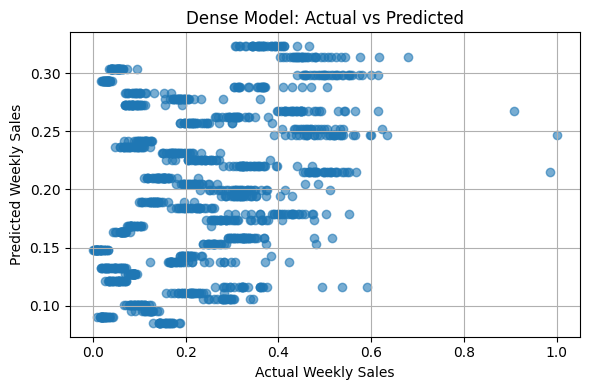

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

X_train_dense = X_train.values
X_test_dense = X_test.values

cnn_model_dense = Sequential()

# Input layer
cnn_model_dense.add(Dense(64, activation='relu', input_dim=X_train_dense.shape[1]))

# Hidden layer
cnn_model_dense.add(Dense(64, activation='relu'))

# Output layer (single value prediction)
cnn_model_dense.add(Dense(1))

# Compile the model
cnn_model_dense.compile(optimizer=Adam(), loss='mean_squared_error')

# Train Dense model
cnn_model_dense.fit(X_train_dense, y_train, epochs=10, batch_size=32, verbose=0)

# Make predictions
cnn_preds_dense = cnn_model_dense.predict(X_test_dense)

# Evaluate the model
cnn_r2 = r2_score(y_test, cnn_preds_dense)
cnn_mse = mean_squared_error(y_test, cnn_preds_dense)

print(f"Dense Model Evaluation:")
print("R² Score:", round(cnn_r2, 4))
print("MSE:", round(cnn_mse, 2))

# scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, cnn_preds_dense, alpha=0.6)
plt.title("Dense Model: Actual vs Predicted")
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.grid(True)
plt.tight_layout()
plt.show()
